In [41]:
# Import dependencies



import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("price2.csv")


In [42]:

# Import and read the data.csv.
df = pd.read_csv("price2.csv")
df
beef_price_jan2022 = df['Price_beef_kilo'].iloc[-1]
rice_price_jan2022 = df['Price_rice_kilo'].iloc[-1]
coffee_price_jan2022 = df['Price_coffee_kilo'].iloc[-1]
df = df.drop(df.index[-1])

df
coffee_price_jan2022


5.98

# Inflation Rate

In [43]:
# Create the Data to predict the inflation rate
df_month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
columns = ['Year', 'Month', 'Price_beef_kilo', 'Price_rice_kilo', 'Price_coffee_kilo', 'Inflation_rate']
df_inflation = df[columns]

# Create the target
y = df_inflation['Inflation_rate']

# Create features
X = df_inflation.drop('Inflation_rate', axis=1)

# Encode month names to numbers
X['Month'] = X['Month'].map({month: i + 1 for i, month in enumerate(df_month_order)})

# Split the data into training and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be 3D (samples, time steps, features) for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(200, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model_lstm.add(LSTM(150, return_sequences=False))
model_lstm.add(Dense(1, activation='linear'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display model summary
model_lstm.summary()

# Train the model
history_lstm = model_lstm.fit(X_train_reshaped, y_train, epochs=200, batch_size=16, validation_data=(X_val_reshaped, y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 200)            164800    
                                                                 
 lstm_8 (LSTM)               (None, 150)               210600    
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 375551 (1.43 MB)
Trainable params: 375551 (1.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
16/16 [==============================] - 3s 41ms/step - loss: 1933.2369 - mae: 35.4729 - val_loss: 1930.2548 - val_mae: 35.2232
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 1886.6127 - mae: 35.1492 - val_loss: 1848.4991 - val_mae: 34.6664
Epo

In [44]:
# Evaluate the model
# MAE and Loss:
loss_lstm, mae_lstm = model_lstm.evaluate(X_test_reshaped, y_test, batch_size=16)
print(f'Test Loss: {loss_lstm}, Test MAE: {mae_lstm}')

# R-squared
predicted_inflation = model_lstm.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, predicted_inflation)

# Print the R-squared value
print(f'R-squared: {r_squared}')

4/4 [==============================] - 0s 2ms/step - loss: 2.6365 - mae: 1.0984
Test Loss: 2.636540174484253, Test MAE: 1.0984444618225098
2/2 [==============================] - 0s 4ms/step
R-squared: 0.9966893770604915


In [45]:
# Create a DataFrame with the input data for January 2022
inflationj_2022_df = pd.DataFrame([{'Year': 2022, 'Month': 1, 'Price_beef_kilo': beef_price_jan2022, 'Price_rice_kilo': rice_price_jan2022, 'Price_coffee_kilo': coffee_price_jan2022}])

# Scale the input features
inflationj_2022_scaled = scaler.transform(inflationj_2022_df[['Year','Month', 'Price_beef_kilo', 'Price_rice_kilo', 'Price_coffee_kilo']])

# Reshape the input data
inflationj_2022_reshaped = inflationj_2022_scaled.reshape((inflationj_2022_scaled.shape[0], 1, inflationj_2022_scaled.shape[1]))

# Predict inflation rate for January 2022
predicted_inflationj_2022 = model_lstm.predict(inflationj_2022_reshaped)

# Print the predicted inflation rate
print(f"Predicted inflation rate for January 2022: {predicted_inflationj_2022[0][0]}")

# Use the trained LSTM model to predict the inflation rate for the test
predicted_inflation_test = model_lstm.predict(X_test_reshaped)

1/1 [==============================] - 0s 16ms/step
Predicted inflation rate for January 2022: 1.6814123392105103
2/2 [==============================] - 0s 2ms/step


In [46]:
# Use the scaler fitted on the training data to transform the new data
inflationj_2022_scaled = scaler.transform(inflationj_2022_df[['Year', 'Month', 'Price_beef_kilo', 'Price_rice_kilo', 'Price_coffee_kilo']])

# Reshape the input data
inflationj_2022_reshaped = inflationj_2022_scaled.reshape((inflationj_2022_scaled.shape[0], 1, inflationj_2022_scaled.shape[1]))

# Predict inflation rate for January 2022
predicted_inflationj_2022 = model_lstm.predict(inflationj_2022_reshaped)

# Print the predicted inflation rate
print(f"Predicted inflation rate for January 2022: {predicted_inflationj_2022[0][0]}")

1/1 [==============================] - 0s 18ms/step
Predicted inflation rate for January 2022: 1.6814123392105103


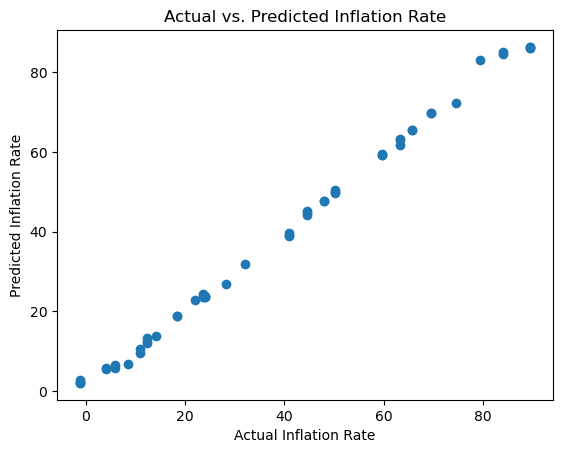

In [47]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predicted_inflation_test)
plt.xlabel('Actual Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.title('Actual vs. Predicted Inflation Rate')
plt.show()

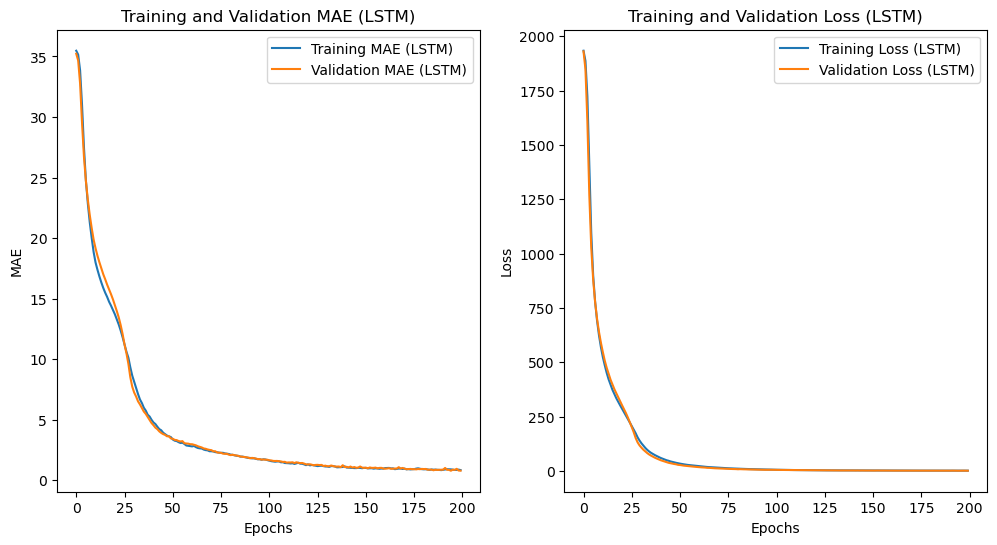

In [48]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['mae'], label='Training MAE (LSTM)')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE (LSTM)')
plt.title('Training and Validation MAE (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss (LSTM)')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)')
plt.title('Training and Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---

---

### Inflation commodity January 2022

In [49]:
# Get the prices of January 2022 provided
old_price_rice = rice_price_jan2022
old_price_beef = beef_price_jan2022
old_price_coffee = coffee_price_jan2022

# Calculate the expected changes in prices based on the predicted inflation rate
predicted_inflation_rate = predicted_inflationj_2022[0][0]

price_rice_infl = old_price_rice * (1 + predicted_inflation_rate/100)
price_beef_infl = old_price_beef * (1 + predicted_inflation_rate/100)
price_coffee_infl = old_price_coffee * (1 + predicted_inflation_rate/100)

# Print the predicted prices
print(f"Rice Inflation: {price_rice_infl}")
print(f"Beef Inflation: {price_beef_infl}")
print(f"Coffee Inflation: {price_coffee_infl}")
predicted_inflationj_2022[0][0]

Rice Inflation: 0.4372300730586052
Beef Inflation: 6.070380316650867
Coffee Inflation: 6.080548457884789


1.6814123

In [50]:
# Create a dictionary to put all the information of January 2022
jan_2022 = {'Year': 2022, 'Month': "Jan", 'Price_beef_kilo': beef_price_jan2022,
                'Price_rice_kilo': rice_price_jan2022,
                'Price_coffee_kilo': coffee_price_jan2022,
                'Inflation_rate': predicted_inflation_rate,
                'Price_rice_infl': round(price_rice_infl ,2),
                'Price_beef_infl': round(price_beef_infl,2),
                'Price_coffee_infl': round(price_coffee_infl,2)
                }
jan_2022

{'Year': 2022,
 'Month': 'Jan',
 'Price_beef_kilo': 5.97,
 'Price_rice_kilo': 0.43,
 'Price_coffee_kilo': 5.98,
 'Inflation_rate': 1.6814123,
 'Price_rice_infl': 0.44,
 'Price_beef_infl': 6.07,
 'Price_coffee_infl': 6.08}

In [51]:
# Create a Dataframe with the new row
dfj = df.append(jan_2022, ignore_index=True)
dfj.tail()

C:\Users\romej\AppData\Local\Temp\ipykernel_21084\331352795.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfj = df.append(jan_2022, ignore_index=True)


,Year,Month,Price_beef_kilo,Price_rice_kilo,Price_coffee_kilo,Inflation_rate,Price_rice_infl,Price_beef_infl,Price_coffee_infl
355,2021,Sep,5.66,0.40,4.97,-1.290000,0.39,5.59,4.91
356,2021,Oct,5.70,0.40,5.31,-1.290000,0.39,5.63,5.24
357,2021,Nov,5.95,0.40,5.71,-1.290000,0.39,5.87,5.64
358,2021,Dec,5.95,0.40,5.91,-1.290000,0.39,5.87,5.83
359,2022,Jan,5.97,0.43,5.98,1.681412,0.44,6.07,6.08


### Predict commidity price

#### Predict Beef Price

In [52]:
# Create the dataframe to predict the beef price
columns = ['Year', 'Month', 'Price_beef_kilo']
df_b= df[columns]
df_b


,Year,Month,Price_beef_kilo
0,1992,Feb,2.52
1,1992,Mar,2.45
2,1992,Apr,2.38
3,1992,May,2.38
4,1992,Jun,2.33
...,...,...,...
354,2021,Aug,5.61
355,2021,Sep,5.66
356,2021,Oct,5.70
357,2021,Nov,5.95


In [53]:
# Create target and features X and y
y = df_b['Price_beef_kilo']

# Drop the target
X = df_b.drop('Price_beef_kilo', axis=1)


month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
X['Month'] = X['Month'].map({month: i + 1 for i, month in enumerate(month_order)})


In [54]:
# Create the train, validation, and test data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be 3D (samples, time steps, features) for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model for beef price prediction
model_lstm_beef = Sequential()
model_lstm_beef.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm_beef.add(Dense(1, activation='linear'))

# Compile the model
model_lstm_beef.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


# Train the model
history_lstm_beef = model_lstm_beef.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_val_reshaped, y_val))


Epoch 1/100
16/16 [==============================] - 2s 24ms/step - loss: 11.1924 - mae: 3.1393 - val_loss: 10.7984 - val_mae: 3.1023
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 10.7096 - mae: 3.0767 - val_loss: 10.3181 - val_mae: 3.0383
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 10.2135 - mae: 3.0096 - val_loss: 9.7812 - val_mae: 2.9648
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 9.6708 - mae: 2.9340 - val_loss: 9.1764 - val_mae: 2.8793
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 9.0439 - mae: 2.8423 - val_loss: 8.5056 - val_mae: 2.7791
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 8.3261 - mae: 2.7333 - val_loss: 7.7494 - val_mae: 2.6593
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 7.5442 - mae: 2.6070 - val_loss: 6.9086 - val_mae: 2.5195
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 6.69

In [55]:
# Evaluate the model
# MAE and Loss:
loss_lstm, mae_lstm = model_lstm_beef.evaluate(X_test_reshaped, y_test, batch_size=16)
print(f'Test Loss: {loss_lstm}, Test MAE: {mae_lstm}')

# R-squared
predicted_inflation = model_lstm_beef.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, predicted_inflation)

# Print the R-squared value
print(f'R-squared: {r_squared}')

4/4 [==============================] - 0s 2ms/step - loss: 0.2173 - mae: 0.3822
Test Loss: 0.21725112199783325, Test MAE: 0.3822477459907532
2/2 [==============================] - 0s 926us/step
R-squared: 0.8484090194679712


In [56]:
# Predict Beef Price for February 2022
# Create a DataFrame with the input data for February 2022
beef_2022_df = pd.DataFrame([{'Year': 2022, 'Month': 2}])

# Use the new scaler instance fitted with beef features
beef_2022_scaled = scaler.transform(beef_2022_df)
beef_2022_reshaped = beef_2022_scaled.reshape((beef_2022_scaled.shape[0], 1, beef_2022_scaled.shape[1]))

# Use the trained LSTM model to predict the beef price
predicted_beef_price_2022 =model_lstm_beef.predict(beef_2022_reshaped)



# Print the predicted beef price
print(f"Predicted Beef Price for February 2022: {predicted_beef_price_2022[0][0]}")

# Use the trained LSTM model to predict the beef prices for the test
predicted_beef_prices_lstm = model_lstm_beef.predict(X_test_reshaped)

1/1 [==============================] - 0s 18ms/step
Predicted Beef Price for February 2022: 5.451414108276367
2/2 [==============================] - 0s 2ms/step


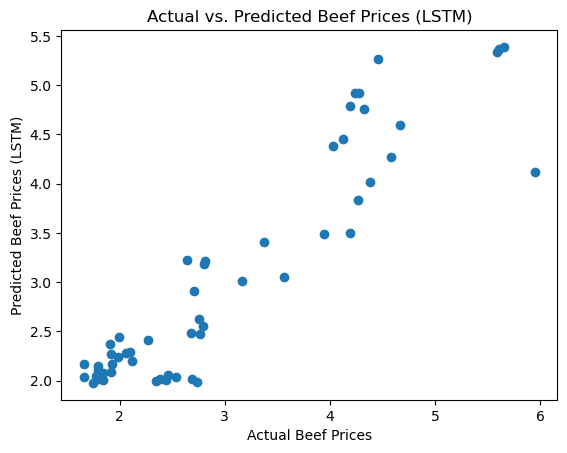

In [57]:
# Plotting actual vs. predicted for LSTM beef prices
plt.scatter(y_test, predicted_beef_prices_lstm)
plt.xlabel('Actual Beef Prices')
plt.ylabel('Predicted Beef Prices (LSTM)')
plt.title('Actual vs. Predicted Beef Prices (LSTM)')
plt.show()


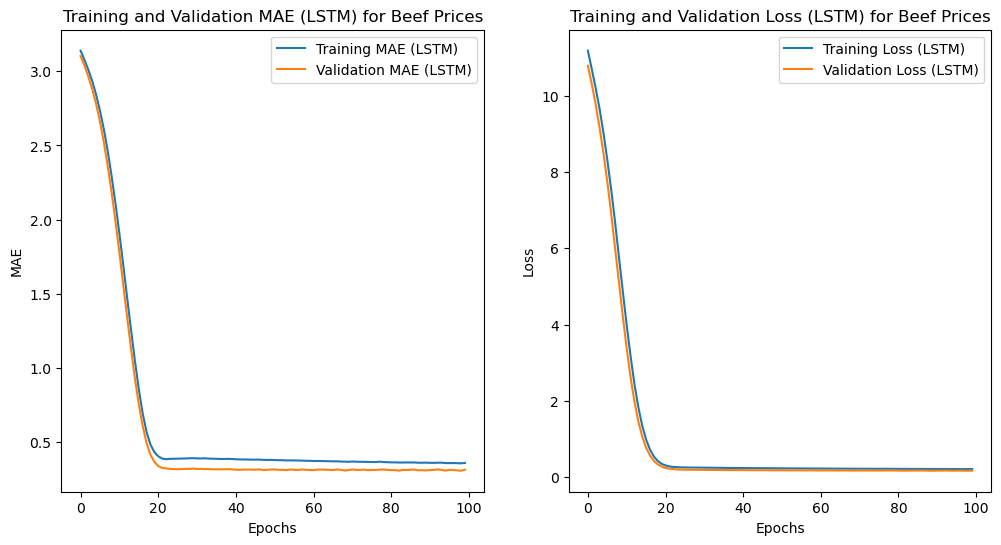

In [58]:
# Plot training and validation metrics for LSTM beef prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_beef.history['mae'], label='Training MAE (LSTM)')
plt.plot(history_lstm_beef.history['val_mae'], label='Validation MAE (LSTM)')
plt.title('Training and Validation MAE (LSTM) for Beef Prices')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm_beef.history['loss'], label='Training Loss (LSTM)')
plt.plot(history_lstm_beef.history['val_loss'], label='Validation Loss (LSTM)')
plt.title('Training and Validation Loss (LSTM) for Beef Prices')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict Rice Price


In [59]:
# Create the dataframe to predict the rice price
columns = ['Year', 'Month', 'Price_rice_kilo']
df_r= df[columns]
df_r

,Year,Month,Price_rice_kilo
0,1992,Feb,0.28
1,1992,Mar,0.28
2,1992,Apr,0.28
3,1992,May,0.27
4,1992,Jun,0.27
...,...,...,...
354,2021,Aug,0.40
355,2021,Sep,0.40
356,2021,Oct,0.40
357,2021,Nov,0.40


In [60]:
#  Create the target
y = df_r['Price_rice_kilo']
# Create features
X = df_r.drop('Price_rice_kilo', axis=1)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
X['Month'] = X['Month'].map({month: i + 1 for i, month in enumerate(month_order)})


In [61]:
# Create the train, validation, and test data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be 3D (samples, time steps, features) for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model for rice price prediction
model_lstm_rice = Sequential()
model_lstm_rice.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm_rice.add(Dense(1, activation='linear'))

# Compile the model
model_lstm_rice.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model_lstm_rice.summary()

# Train the model
history_lstm_rice = model_lstm_rice.fit(X_train_reshaped, y_train, epochs=150, batch_size=16, validation_data=(X_val_reshaped, y_val))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                10600     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
16/16 [==============================] - 2s 24ms/step - loss: 0.1286 - mae: 0.3353 - val_loss: 0.1136 - val_mae: 0.3148
Epoch 2/150
16/16 [==============================] - 0s 3ms/step - loss: 0.0862 - mae: 0.2734 - val_loss: 0.0776 - val_mae: 0.2545
Epoch 3/150
16/16 [==============================] - 0s 3ms/step - loss: 0.0547 - mae: 0.2103 - val_loss: 0.0493 - val_mae: 0.1908
Epoch 4/150
16/16 [=

In [62]:
# Evaluate the model
# MAE and Loss:
loss_lstm, mae_lstm =model_lstm_rice.evaluate(X_test_reshaped, y_test, batch_size=16)
print(f'Test Loss: {loss_lstm}, Test MAE: {mae_lstm}')

# R-squared
predicted_rice = model_lstm_rice.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, predicted_rice)

# Print the R-squared value
print(f'R-squared: {r_squared}')

4/4 [==============================] - 0s 2ms/step - loss: 0.0126 - mae: 0.0807
Test Loss: 0.012584775686264038, Test MAE: 0.08066431432962418
2/2 [==============================] - 0s 2ms/step
R-squared: 0.3781790150058194


In [63]:
# Predict Rice Price for February 2022
# Create a DataFrame with the input data for February 2022
rice_2022_df = pd.DataFrame([{'Year': 2022, 'Month': 2}])

# Use the new scaler instance fitted with rice features
rice_2022_scaled = scaler.transform(rice_2022_df)
rice_2022_reshaped = rice_2022_scaled.reshape((rice_2022_scaled.shape[0], 1, rice_2022_scaled.shape[1]))

# Use the trained LSTM model to predict the rice price
predicted_rice_price_2022 = model_lstm_rice.predict(rice_2022_reshaped)

# Print the predicted rice price
print(f"Predicted Rice Price for February 2022: {predicted_rice_price_2022[0][0]}")

# Use the trained LSTM model to predict the rice prices for the test set
predicted_rice_prices_lstm = model_lstm_rice.predict(X_test_reshaped)

1/1 [==============================] - 0s 21ms/step
Predicted Rice Price for February 2022: 0.4643620550632477
2/2 [==============================] - 0s 6ms/step


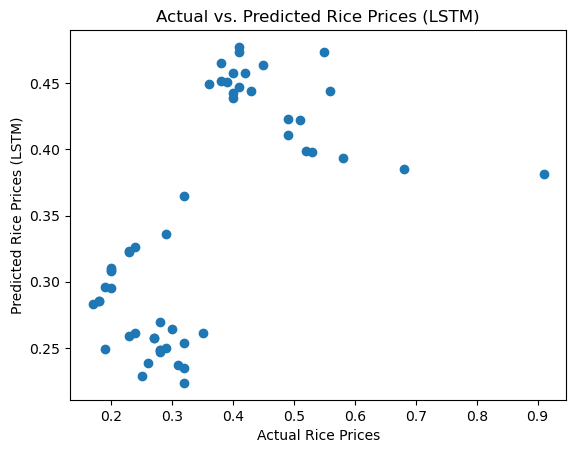

In [64]:
# Plotting actual vs. predicted for LSTM rice prices
plt.scatter(y_test, predicted_rice_prices_lstm)
plt.xlabel('Actual Rice Prices')
plt.ylabel('Predicted Rice Prices (LSTM)')
plt.title('Actual vs. Predicted Rice Prices (LSTM)')
plt.show()

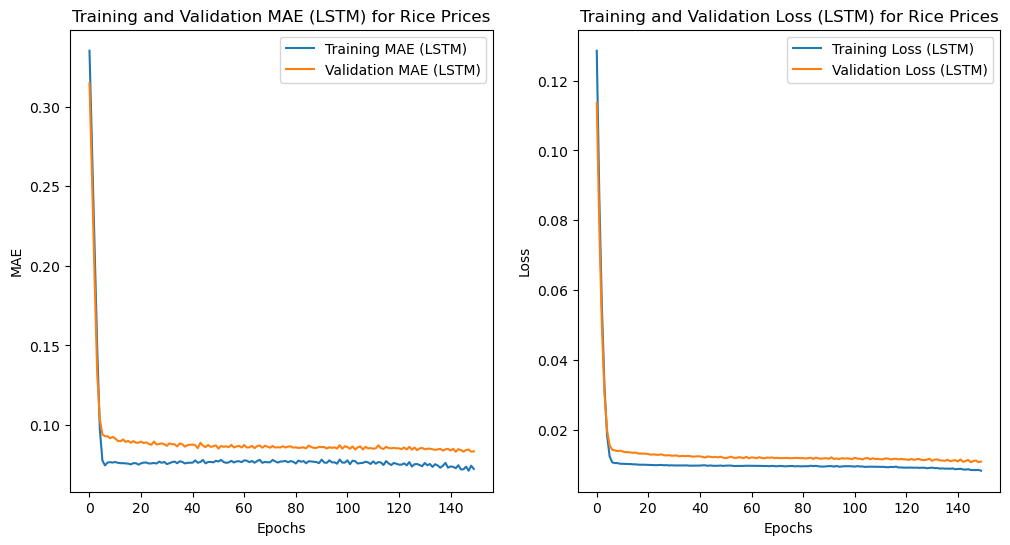

In [65]:
# Plot training and validation metrics for LSTM rice prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_rice.history['mae'], label='Training MAE (LSTM)')
plt.plot(history_lstm_rice.history['val_mae'], label='Validation MAE (LSTM)')
plt.title('Training and Validation MAE (LSTM) for Rice Prices')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm_rice.history['loss'], label='Training Loss (LSTM)')
plt.plot(history_lstm_rice.history['val_loss'], label='Validation Loss (LSTM)')
plt.title('Training and Validation Loss (LSTM) for Rice Prices')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict Coffee Price


In [66]:
# Create the dataframe to predict the coffee price
columns = ['Year', 'Month', 'Price_coffee_kilo']
df_c= df[columns]
df_c

,Year,Month,Price_coffee_kilo
0,1992,Feb,1.51
1,1992,Mar,1.55
2,1992,Apr,1.45
3,1992,May,1.34
4,1992,Jun,1.30
...,...,...,...
354,2021,Aug,4.77
355,2021,Sep,4.97
356,2021,Oct,5.31
357,2021,Nov,5.71


In [67]:
#  Create the target
y = df_c['Price_coffee_kilo']

# Create features
X = df_c.drop('Price_coffee_kilo', axis=1)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
X['Month'] = X['Month'].map({month: i + 1 for i, month in enumerate(month_order)})


In [68]:
# Create the train, validation, and test data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be 3D (samples, time steps, features) for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model for coffee price prediction
model_lstm_coffee = Sequential()
model_lstm_coffee.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm_coffee.add(Dense(1, activation='linear'))

# Compile the model
model_lstm_coffee.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model_lstm_coffee.summary()

# Train the model
history_lstm_coffee = model_lstm_coffee.fit(X_train_reshaped, y_train, epochs=150, batch_size=16, validation_data=(X_val_reshaped, y_val))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50)                10600     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
16/16 [==============================] - 2s 22ms/step - loss: 10.0392 - mae: 2.9692 - val_loss: 10.4807 - val_mae: 3.0479
Epoch 2/150
16/16 [==============================] - 0s 3ms/step - loss: 9.6786 - mae: 2.9125 - val_loss: 10.1064 - val_mae: 2.9882
Epoch 3/150
16/16 [==============================] - 0s 3ms/step - loss: 9.2878 - mae: 2.8476 - val_loss: 9.6742 - val_mae: 2.9172
Epoch 4/150
16/16

In [69]:
# Evaluate the model
# MAE and Loss:
loss_lstm, mae_lstm =model_lstm_coffee.evaluate(X_test_reshaped, y_test, batch_size=16)
print(f'Test Loss: {loss_lstm}, Test MAE: {mae_lstm}')

# R-squared
predicted_rice = model_lstm_coffee.predict(X_test_reshaped)

# Calculate R-squared
r_squared = r2_score(y_test, predicted_rice)

# Print the R-squared value
print(f'R-squared: {r_squared}')

4/4 [==============================] - 0s 2ms/step - loss: 1.1386 - mae: 0.8583
Test Loss: 1.1385787725448608, Test MAE: 0.8582658171653748
2/2 [==============================] - 0s 1ms/step
R-squared: 0.3113459528898026


In [70]:
# Predict Coffee Price for February 2022
# Create a DataFrame with the input data for February 2022
coffee_2022_df = pd.DataFrame([{'Year': 2022, 'Month': 2}])

# Use the new scaler instance fitted with coffee features
coffee_2022_scaled = scaler.transform(coffee_2022_df)
coffee_2022_reshaped = coffee_2022_scaled.reshape((coffee_2022_scaled.shape[0], 1, coffee_2022_scaled.shape[1]))

# Use the trained LSTM model to predict the coffee price
predicted_coffee_price_2022 = model_lstm_coffee.predict(coffee_2022_reshaped)

# Print the predicted coffee price
print(f"Predicted Coffee Price for February 2022: {predicted_coffee_price_2022[0][0]}")

# Use the trained LSTM model to predict the coffee prices for the test
predicted_coffee_prices_lstm = model_lstm_coffee.predict(X_test_reshaped)

1/1 [==============================] - 0s 18ms/step
Predicted Coffee Price for February 2022: 3.9400038719177246
2/2 [==============================] - 0s 1ms/step


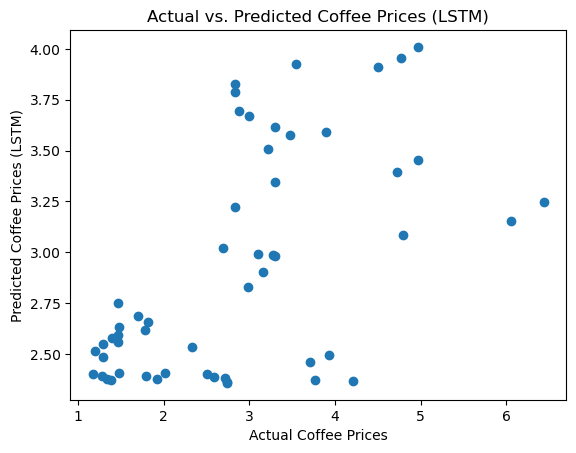

In [71]:
# Plotting actual vs. predicted for LSTM coffee prices
plt.scatter(y_test, predicted_coffee_prices_lstm)
plt.xlabel('Actual Coffee Prices')
plt.ylabel('Predicted Coffee Prices (LSTM)')
plt.title('Actual vs. Predicted Coffee Prices (LSTM)')
plt.show()

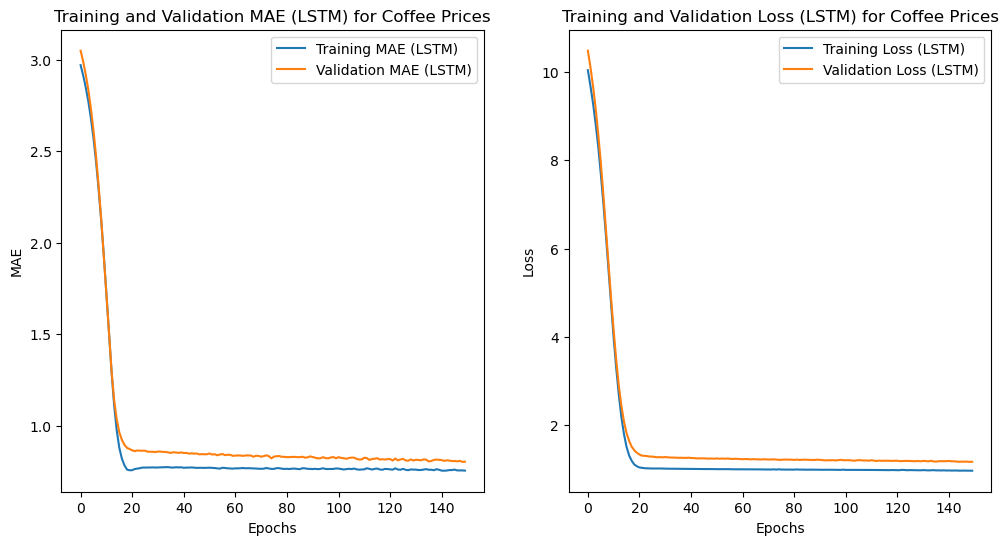

In [72]:
# Plot training and validation metrics for LSTM coffee prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_coffee.history['mae'], label='Training MAE (LSTM)')
plt.plot(history_lstm_coffee.history['val_mae'], label='Validation MAE (LSTM)')
plt.title('Training and Validation MAE (LSTM) for Coffee Prices')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm_coffee.history['loss'], label='Training Loss (LSTM)')
plt.plot(history_lstm_coffee.history['val_loss'], label='Validation Loss (LSTM)')
plt.title('Training and Validation Loss (LSTM) for Coffee Prices')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Create the dataframe with predicted prices of 2022

In [73]:
# Create a new DataFrame for months 2 to 12
new_df = pd.DataFrame({'Year': [2022] * 11, 'Month': list(range(2, 13))})

# Use joblib to parallelize the predictions
results = []
for index, row in new_df.iterrows():
    month = row['Month']
    input_data = new_df[new_df['Month'] == month]

    if input_data.empty:
        print(f"Input data for month {month} is empty.")
        continue

    # Create the features
    X = input_data[['Year', 'Month']]

    # Scale the input features
    X_scaled = scaler.transform(X)
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Predict prices for beef, rice, and coffee using LSTM models
    predicted_beef = model_lstm_beef.predict(X_reshaped)
    predicted_rice = model_lstm_rice.predict(X_reshaped)
    predicted_coffee = model_lstm_coffee.predict(X_reshaped)

    prediction = month, predicted_beef[0][0], predicted_rice[0][0], predicted_coffee[0][0]
    results.append(prediction)

# Create the DataFrame for predicted values
predictions_df = pd.DataFrame(results, columns=['Month', 'Predicted_beef', 'Predicted_rice', 'Predicted_coffee'])

# Display the DataFrame
predictions_df

1/1 [==============================] - 0s 16ms/step


,Month,Predicted_beef,Predicted_rice,Predicted_coffee
0,2,5.451414,0.464362,3.940004
1,3,5.461143,0.459261,3.920961
2,4,5.473464,0.454229,3.916045
3,5,5.488343,0.449319,3.925241
4,6,5.505725,0.444582,3.948095
5,7,5.525543,0.440066,3.983739
6,8,5.547732,0.435815,4.030953
7,9,5.572254,0.431870,4.088267
8,10,5.599095,0.428265,4.154068
9,11,5.628291,0.425031,4.226711


In [74]:
# Assign the months name
month_name = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
predictions_df
# Convert Months from number to name
predictions_df['Month'] = predictions_df['Month'].map(month_name)
# Reorder columns
predictions_df['Year'] = 2022
predictions_df = predictions_df[['Year', 'Month', 'Predicted_beef', 'Predicted_rice', 'Predicted_coffee']]
# Display the Dataframe
predictions_df

,Year,Month,Predicted_beef,Predicted_rice,Predicted_coffee
0,2022,Feb,5.451414,0.464362,3.940004
1,2022,Mar,5.461143,0.459261,3.920961
2,2022,Apr,5.473464,0.454229,3.916045
3,2022,May,5.488343,0.449319,3.925241
4,2022,Jun,5.505725,0.444582,3.948095
5,2022,Jul,5.525543,0.440066,3.983739
6,2022,Aug,5.547732,0.435815,4.030953
7,2022,Sep,5.572254,0.431870,4.088267
8,2022,Oct,5.599095,0.428265,4.154068
9,2022,Nov,5.628291,0.425031,4.226711


In [75]:
# Add the new predicted prices to the Dataframe
df2022=dfj
for index, row in predictions_df.iterrows():
    year = row['Year']
    month = row['Month']
    predicted_beef = row['Predicted_beef']
    predicted_rice = row['Predicted_rice']
    predicted_coffee = row['Predicted_coffee']

    # Add a new row to the Dataframe
    new_row = {'Year': year, 'Month': month, 'Price_beef_kilo': predicted_beef, 'Price_rice_kilo': predicted_rice, 'Price_coffee_kilo': predicted_coffee}
    df2022 = df2022.append(new_row, ignore_index=True)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df2022['Month'] = df2022['Month'].map({month: i + 1 for i, month in enumerate(month_order)})

# Display the new DataFrame
df2022.tail(12)

C:\Users\romej\AppData\Local\Temp\ipykernel_21084\3047874181.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2022 = df2022.append(new_row, ignore_index=True)
C:\Users\romej\AppData\Local\Temp\ipykernel_21084\3047874181.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2022 = df2022.append(new_row, ignore_index=True)
C:\Users\romej\AppData\Local\Temp\ipykernel_21084\3047874181.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2022 = df2022.append(new_row, ignore_index=True)
C:\Users\romej\AppData\Local\Temp\ipykernel_21084\3047874181.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2022 = df2022.append(new_row, ign

,Year,Month,Price_beef_kilo,Price_rice_kilo,Price_coffee_kilo,Inflation_rate,Price_rice_infl,Price_beef_infl,Price_coffee_infl
359,2022,1,5.970000,0.430000,5.980000,1.681412,0.44,6.07,6.08
360,2022,2,5.451414,0.464362,3.940004,NaN,NaN,NaN,NaN
361,2022,3,5.461143,0.459261,3.920961,NaN,NaN,NaN,NaN
362,2022,4,5.473464,0.454229,3.916045,NaN,NaN,NaN,NaN
363,2022,5,5.488343,0.449319,3.925241,NaN,NaN,NaN,NaN
364,2022,6,5.505725,0.444582,3.948095,NaN,NaN,NaN,NaN
365,2022,7,5.525543,0.440066,3.983739,NaN,NaN,NaN,NaN
366,2022,8,5.547732,0.435815,4.030953,NaN,NaN,NaN,NaN
367,2022,9,5.572254,0.431870,4.088267,NaN,NaN,NaN,NaN
368,2022,10,5.599095,0.428265,4.154068,NaN,NaN,NaN,NaN


### Predict the inflation rate for the rest of 2022

In [76]:
# Reuse the inflation model to refresh the variables used
# Create the Data to predict the inflation rate
df_month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
columns = ['Year', 'Month', 'Price_beef_kilo', 'Price_rice_kilo', 'Price_coffee_kilo', 'Inflation_rate']
df_inflation = df[columns]

# Create the target
y = df_inflation['Inflation_rate']

# Create features
X = df_inflation.drop('Inflation_rate', axis=1)

# Encode month names to numbers
X['Month'] = X['Month'].map({month: i + 1 for i, month in enumerate(df_month_order)})

# Split the data into training and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be 3D (samples, time steps, features) for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(200, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model_lstm.add(LSTM(150, return_sequences=False))
model_lstm.add(Dense(1, activation='linear'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display model summary
model_lstm.summary()

# Train the model
history_lstm = model_lstm.fit(X_train_reshaped, y_train, epochs=200, batch_size=16, validation_data=(X_val_reshaped, y_val))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 200)            164800    
                                                                 
 lstm_13 (LSTM)              (None, 150)               210600    
                                                                 
 dense_9 (Dense)             (None, 1)                 151       
                                                                 
Total params: 375551 (1.43 MB)
Trainable params: 375551 (1.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
16/16 [==============================] - 3s 40ms/step - loss: 1934.2340 - mae: 35.4818 - val_loss: 1932.8270 - val_mae: 35.2420
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 1890.0306 - mae: 35.1601 - val_loss: 1860.1665 - val_mae: 34.7469
Epo

In [79]:
# Extract the input features for the prediction months (Feb to Dec 2022)
X_predict = df2022.loc[:, ['Year', 'Month', 'Price_beef_kilo', 'Price_rice_kilo', 'Price_coffee_kilo']]

# Scale the input features
X_predict_scaled = scaler.transform(X_predict)

# Reshape input data to be 3D (samples, time steps, features) for LSTM
X_predict_reshaped = X_predict_scaled.reshape((X_predict_scaled.shape[0], 1, X_predict_scaled.shape[1]))

# Predict inflation rates using the trained LSTM model
y_predict = model_lstm.predict(X_predict_reshaped)


# Fill NaN values in the original DataFrame
df2022['Inflation_rate'] = y_predict_original_scale

# Display the DataFrame with predicted inflation rates
df2022.tail(15)

12/12 [==============================] - 0s 3ms/step


,Year,Month,Price_beef_kilo,Price_rice_kilo,Price_coffee_kilo,Inflation_rate,Price_rice_infl,Price_beef_infl,Price_coffee_infl
356,2021,10,5.700000,0.400000,5.310000,5.164014,0.390000,5.630000,5.240000
357,2021,11,5.950000,0.400000,5.710000,5.044203,0.420177,5.987520,5.577847
358,2021,12,5.950000,0.400000,5.910000,5.016303,0.441254,6.287872,5.857649
359,2022,1,5.970000,0.430000,5.980000,4.811404,0.462485,6.590407,6.139484
360,2022,2,5.451414,0.464362,3.940004,5.078840,0.485974,6.925123,6.451299
361,2022,3,5.461143,0.459261,3.920961,5.045170,0.510492,7.274507,6.776778
362,2022,4,5.473464,0.454229,3.916045,5.014676,0.536091,7.639300,7.116611
363,2022,5,5.488343,0.449319,3.925241,4.987040,0.562826,8.020275,7.471519
364,2022,6,5.505725,0.444582,3.948095,4.962031,0.590754,8.418243,7.842258
365,2022,7,5.525543,0.440066,3.983739,4.939511,0.619934,8.834064,8.229628


### Calculate the prices inflation

In [78]:
# Initialize the prices for the first row
initial_prices = df2022.loc[356, ['Price_rice_kilo', 'Price_beef_kilo', 'Price_coffee_kilo']].values

# Columns to update
inflated_price_columns = ['Price_rice_infl', 'Price_beef_infl', 'Price_coffee_infl']

# Loop through the DataFrame starting from the second row (index 357)
for i in range(357, len(df2022)):
    # Get the inflation rates for the current row
    inflation_rates = df2022.loc[i, 'Inflation_rate']

    # Check if inflation_rates is not NaN
    if not np.isnan(inflation_rates):
        # Calculate inflated prices using the previous month's prices and inflation rates
        inflated_prices = initial_prices * (1 + inflation_rates / 100)

        # Update the inflated prices in the DataFrame
        df2022.loc[i, inflated_price_columns] = inflated_prices

        # Set the inflated prices as the initial prices for the next iteration
        initial_prices = inflated_prices

# Display the updated DataFrame
df2022.tail(13)

,Year,Month,Price_beef_kilo,Price_rice_kilo,Price_coffee_kilo,Inflation_rate,Price_rice_infl,Price_beef_infl,Price_coffee_infl
358,2021,12,5.950000,0.400000,5.910000,5.016303,0.441254,6.287872,5.857649
359,2022,1,5.970000,0.430000,5.980000,4.811404,0.462485,6.590407,6.139484
360,2022,2,5.451414,0.464362,3.940004,5.078840,0.485974,6.925123,6.451299
361,2022,3,5.461143,0.459261,3.920961,5.045170,0.510492,7.274507,6.776778
362,2022,4,5.473464,0.454229,3.916045,5.014676,0.536091,7.639300,7.116611
363,2022,5,5.488343,0.449319,3.925241,4.987040,0.562826,8.020275,7.471519
364,2022,6,5.505725,0.444582,3.948095,4.962031,0.590754,8.418243,7.842258
365,2022,7,5.525543,0.440066,3.983739,4.939511,0.619934,8.834064,8.229628
366,2022,8,5.547732,0.435815,4.030953,4.919416,0.650431,9.268648,8.634477
367,2022,9,5.572254,0.431870,4.088267,4.901736,0.682314,9.722972,9.057716
